# Домашнее задание №7 -  Рекурентные сети для обработки последовательностей

Обучить GRU, LSTM для предсказания временного ряда на примере https://www.kaggle.com/c/favorita-grocery-sales-forecasting (для каждого типа продуктов)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
input = {
    'train': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/train.csv', dtype=dtypes, parse_dates=['date']),
    'test': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/test.csv', dtype=dtypes, parse_dates=['date']),
    'items': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/items.csv'),
    'stores': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/stores.csv'),
    'trans': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/transactions.csv', parse_dates=['date']),
    'holidays': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/holidays_events.csv', dtype={'transferred':str}, parse_dates=['date']),
    'oil': pd.read_csv('/content/drive/MyDrive/PyTorch_Intro/oil.csv', parse_dates=['date']),
    }

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


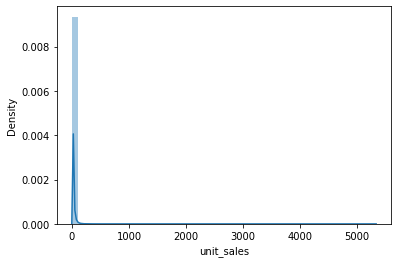

In [4]:
#P0) pick only for AUG data from train.csv, concerning the seasoning impact etc.
train = input['train'][(input['train']['date'].dt.month == 8) & (input['train']['date'].dt.day > 15)]
#P1) Negative values of unit_sales represent returns of that particular item
# => in prediction, returns means same as zero_sales - so convert to 0                       
unit_sales = train['unit_sales'].values
unit_sales[unit_sales < 0.] = 0.
#check histogram and see if better to log-transform
seaborn.distplot(train['unit_sales']);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


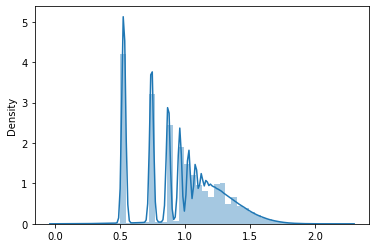

In [5]:
train['unit_sales'] = np.log1p(unit_sales)
seaborn.distplot(np.log1p(unit_sales));

In [6]:
#P5) stores - city, state, type, and cluster. cluster is a grouping of similar stores.
train = pd.merge(train, input['stores'], how='left', on=['store_nbr'])

#P6) items - family, class, and perishable.
#P7) Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0.
#input['items'] = proc_object_data(input['items'])
train = pd.merge(train, input['items'], how='left', on=['item_nbr'])

#P9) Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
train = pd.merge(train, input['oil'], how='left', on=['date'])

#P8) The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.
# => consider that transaction volume may not have relation with sales qty for each product - so ignore.
train.head(n=10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico
0,9767476,2013-08-16,1,96995,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1093,0,107.58
1,9767477,2013-08-16,1,103665,1.098612,NaN,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,107.58
2,9767478,2013-08-16,1,105574,1.609438,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58
3,9767479,2013-08-16,1,105575,2.484907,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58
4,9767480,2013-08-16,1,105577,1.945910,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58
5,9767481,2013-08-16,1,105737,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1044,0,107.58
6,9767482,2013-08-16,1,105857,2.772589,NaN,Quito,Pichincha,D,13,GROCERY I,1092,0,107.58
7,9767483,2013-08-16,1,106716,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1032,0,107.58
8,9767484,2013-08-16,1,108079,1.609438,NaN,Quito,Pichincha,D,13,GROCERY I,1030,0,107.58
9,9767485,2013-08-16,1,108696,1.098612,NaN,Quito,Pichincha,D,13,DELI,2636,1,107.58


In [7]:
#P10) A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. 
# => filter out : transferred == 'TRUE'
holevts = input['holidays']
holevts = holevts[(holevts.transferred != 'TRUE') & (holevts.transferred != 'True')]
# Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). 
# These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
# => filter out : type = 'Work Day'
holevts = holevts[holevts.type != 'Work Day']
#Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday)
#type (Holiday, Transfer, Bridge, Additional) => Holiday // type (Event) => Event
holevts['on_hol'] = holevts['type'].map({"Holiday":"Holiday", "Transfer":"Holiday", "Bridge":"Holiday", "Additional":"Holiday"})
holevts['on_evt'] = holevts['type'].map({"Event":"Event"})
col = [c for c in holevts if c in ['date', 'locale_name','on_hol','on_evt']]
holevts_L = holevts[holevts.locale == 'Local'][col].rename(columns={'locale_name':'city'})
holevts_R = holevts[holevts.locale == 'Regional'][col].rename(columns={'locale_name':'state'})
holevts_N = holevts[holevts.locale == 'National'][col]

# Actually our test data is only for 2017.08.16~20, at which there's no holiday - hene it won't impact this case. 
# But still proceed to prepare factors (on_hol, on_evt) as these might be one of key factor in general.
train = pd.merge(train, holevts_L, how='left', on=['date','city'])
train = pd.merge(train, holevts_R, how='left', on=['date','state'])
train = pd.merge(train, holevts_N, how='left', on=['date'])

train.head(n=10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico,on_hol_x,on_evt_x,on_hol_y,on_evt_y,locale_name,on_hol,on_evt
0,9767476,2013-08-16,1,96995,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1093,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9767477,2013-08-16,1,103665,1.098612,NaN,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9767478,2013-08-16,1,105574,1.609438,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9767479,2013-08-16,1,105575,2.484907,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9767480,2013-08-16,1,105577,1.945910,NaN,Quito,Pichincha,D,13,GROCERY I,1045,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9767481,2013-08-16,1,105737,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1044,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9767482,2013-08-16,1,105857,2.772589,NaN,Quito,Pichincha,D,13,GROCERY I,1092,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9767483,2013-08-16,1,106716,1.386294,NaN,Quito,Pichincha,D,13,GROCERY I,1032,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9767484,2013-08-16,1,108079,1.609438,NaN,Quito,Pichincha,D,13,GROCERY I,1030,0,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9767485,2013-08-16,1,108696,1.098612,NaN,Quito,Pichincha,D,13,DELI,2636,1,107.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def proc_data(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['date'] = df['date'].dt.dayofweek    
    df['wage'] = df['day'].map({15:1, 31:1})
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df['on_hol'] = np.where(df[["on_hol_x","on_hol_y","on_hol"]].apply(lambda x: x.str.contains('Holiday')).any(1), 1,0)
    df['on_evt'] = np.where(df[["on_evt_x","on_evt_y","on_evt"]].apply(lambda x: x.str.contains('Event')).any(1), 1,0)
    df = df.drop(["on_hol_x","on_hol_y","on_evt_x","on_evt_y","locale_name"], axis=1)
    df = df.fillna(-1)
    return df

data = proc_data(train)

In [9]:
data.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico,on_hol,on_evt,year,month,day,wage
0,9767476,4,1,96995,1.386294,-1.0,Quito,Pichincha,D,13,GROCERY I,1093,1.00,107.58,0,0,2013,8,16,-1.0
1,9767477,4,1,103665,1.098612,-1.0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1.25,107.58,0,0,2013,8,16,-1.0
2,9767478,4,1,105574,1.609438,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0
3,9767479,4,1,105575,2.484907,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0
4,9767480,4,1,105577,1.945910,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0


In [10]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['state_1'] = labelencoder.fit_transform(data['state'])
data['city_1'] = labelencoder.fit_transform(data['city'])
data['type_1'] = labelencoder.fit_transform(data['type'])
data['family_1'] = labelencoder.fit_transform(data['family'])

data.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico,on_hol,on_evt,year,month,day,wage,state_1,city_1,type_1,family_1
0,9767476,4,1,96995,1.386294,-1.0,Quito,Pichincha,D,13,GROCERY I,1093,1.00,107.58,0,0,2013,8,16,-1.0,12,18,3,11
1,9767477,4,1,103665,1.098612,-1.0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1.25,107.58,0,0,2013,8,16,-1.0,12,18,3,4
2,9767478,4,1,105574,1.609438,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0,12,18,3,11
3,9767479,4,1,105575,2.484907,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0,12,18,3,11
4,9767480,4,1,105577,1.945910,-1.0,Quito,Pichincha,D,13,GROCERY I,1045,1.00,107.58,0,0,2013,8,16,-1.0,12,18,3,11


In [11]:
# Dropping non-numeric columns 
data = data.drop(['id', 'state', 'city', 'type', 'family'], axis=1)

In [12]:
# Splitting on train and test with stated params
train, test = train_test_split(data, test_size=0.25, random_state=13)
train.head(2)

,date,store_nbr,item_nbr,unit_sales,onpromotion,cluster,class,perishable,dcoilwtico,on_hol,on_evt,year,month,day,wage,state_1,city_1,type_1,family_1
2320506,0,39,1161572,0.693147,0.0,6,1040,1.0,38.22,0,0,2015,8,24,-1.0,0,3,1,11
4191619,0,7,890214,2.302585,0.0,8,1026,1.0,46.97,0,0,2016,8,29,-1.0,12,18,3,11


In [13]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data, 'unit_sales', 0.2)

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [16]:
# class FavoritaDataset(torch.utils.data.Dataset):
#     def __init__(self, df, normalize=False, fit_scaler=False):
#         self.df = df.copy()
#         self.normalize = normalize
#         self.scaler = MinMaxScaler()
#         self.fit_scaler = fit_scaler
#         self.sc_fl = 0

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         label = self.df.iloc[idx, -1:]
#         if self.fit_scaler:
#             self.scaler.fit(df.iloc[:, :-1])
#             self.sc_fl = 1

#         if self.normalize and sc_fl:
#             df = scaler.transform(df)

#         tensor = torch.FloatTensor(self.df.iloc[idx, 1:-1].values)
#         label = torch.FloatTensor(label.values)

#         return tensor, label

In [17]:
# train_dataset = FavoritaDataset(train)

# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                            batch_size=2048,
#                                            shuffle=True,
#                                            num_workers=3)

# test_dataset = FavoritaDataset(test)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                           batch_size=2048,
#                                           shuffle=True,
#                                           num_workers=3)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [19]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [20]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [21]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features])
                    y_val = y_val
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)


    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features])
                y_test = y_test
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().numpy())
                values.append(y_test.detach().numpy())

        return predictions, values


    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/1] Training loss: 0.0101	 Validation loss: 0.0115


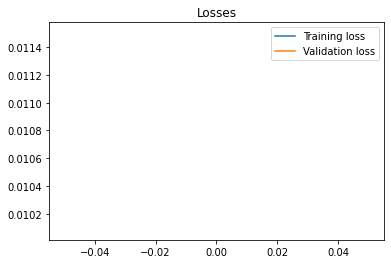

In [ ]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 1
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)